In [1]:
!pip install torch torchvision --quiet


In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


In [3]:
# Transform: convert to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 499kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.68MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.55MB/s]


In [6]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, latent_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, 400)
        self.fc21 = nn.Linear(400, latent_dim)  # mean
        self.fc22 = nn.Linear(400, latent_dim)  # log-variance
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [9]:
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
epochs = 5  # you can increase if runtime allows

for epoch in range(epochs):
    vae.train()
    train_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {train_loss/len(train_loader.dataset):.4f}')


Epoch 1, Loss: 163.9159
Epoch 2, Loss: 120.9144
Epoch 3, Loss: 114.0606
Epoch 4, Loss: 111.1181
Epoch 5, Loss: 109.4245


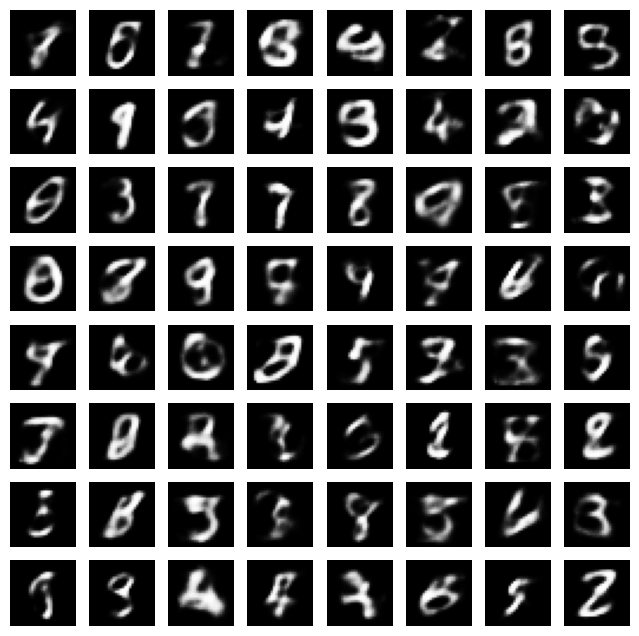

In [11]:
vae.eval()
with torch.no_grad():
    z = torch.randn(64, 20).to(device)
    sample = vae.decode(z).cpu()
    plt.figure(figsize=(8,8))
    for i in range(64):
        plt.subplot(8,8,i+1)
        plt.imshow(sample[i].view(28,28), cmap='gray')
        plt.axis('off')
    plt.show()
